__Example: Known Deflections Source Planes__

In this example, we use an input deflection angle map from an external source to create and investigate the
source-plane of an `Imaging` dataset. This input deflection angle map comes from outside PyAutoLens (how dare you!),
for example:

 - A model of a strong lens computed by another code, like community Hubble Frontier Fields deflection angle maps of
   strongly lensed clusters.
 - Deflection angles of a galaxy simulated in a cosmological galaxy formation simulation.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


In this example, our `input` deflection angle map is the true deflection angles of the `Imaging` dataset simulated in 
the `mass_sie__source_parametric.py` simulator. You should be able to simply edit the `from_fits` methods below to point
to your own dataset and deflection maps.

Lets load and plot this dataset.

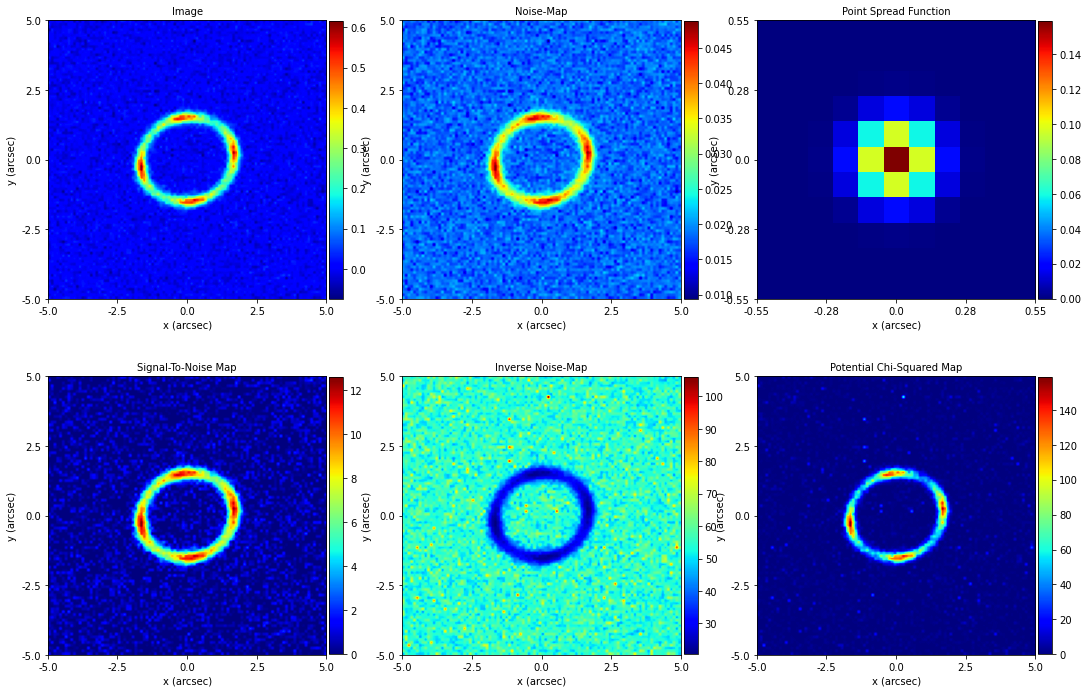

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=0.1,
)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.subplot_imaging()

In `autolens_workspace/examples/misc/files` you`ll find the script `make_source_plane.py`, which creates the 
image-plane  `Grid2D` and deflection angles we use in this example (which are identical to those used in the 
`mass_sie__source_parametric.py` simulator). 

Lets load the input deflection angle map from a .fits files (which is created in the code mentioned above).

In [3]:
deflections_y = al.Array2D.from_fits(
    file_path=path.join("dataset", "misc", "deflections_y.fits"),
    pixel_scales=imaging.pixel_scales,
)
deflections_x = al.Array2D.from_fits(
    file_path=path.join("dataset", "misc", "deflections_x.fits"),
    pixel_scales=imaging.pixel_scales,
)

Lets plot the deflection angles to make sure they look like what we expect!

In [4]:
aplt.Array2DPlotter(array=deflections_y)
aplt.Array2DPlotter(array=deflections_x)

Lets next load and plot the image-plane grid.

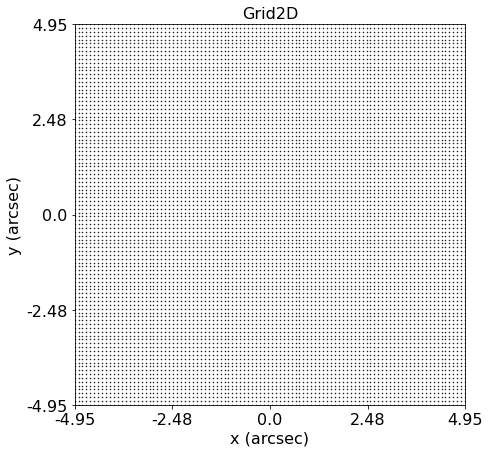

In [5]:
grid = al.Grid2D.from_fits(
    file_path=path.join("dataset", "misc", "grid.fits"),
    pixel_scales=imaging.pixel_scales,
)
grid_plotter = aplt.Grid2DPlotter(grid=grid)
grid_plotter.figure_2d()

We now create our `InputDeflections` `MassProfile`, which represents our input deflection angle map as a 
`MassProfile` in PyAutoLens so that it can be used with objects like `Galaxy`'s and `Tracer`.

This takes as input both the input deflection angles and their corresponding image-plane grid, with the latter used to
compute new sets of deflection angles from the input deflections via interpolation.

In [6]:
image_plane_grid = al.Grid2D.uniform(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales
)
input_deflections = al.mp.InputDeflections(
    deflections_y=deflections_y,
    deflections_x=deflections_x,
    image_plane_grid=image_plane_grid,
)

When we create the `InputDeflections` above we do not apply a mask to the deflection angles. This is an intentional
choice to ensure we do not remove any information which may be used later when using the deflections. 

However, we may only want to to use these deflection angles to ray-trace a localized region of the image-plane
to the source-plane (e.g. the regions where the source is located). To do this, we simply pass the _InputDeflections_
the (masked) grid we want its interpolated deflection angles from. 

In [7]:
mask = al.Mask2D.circular(
    shape_native=grid.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

grid = al.Grid2D.from_mask(mask=mask)

The deflections will be computed only in the regions included on the `Grid2D`, e.g. the 3.0" mask we defined above.

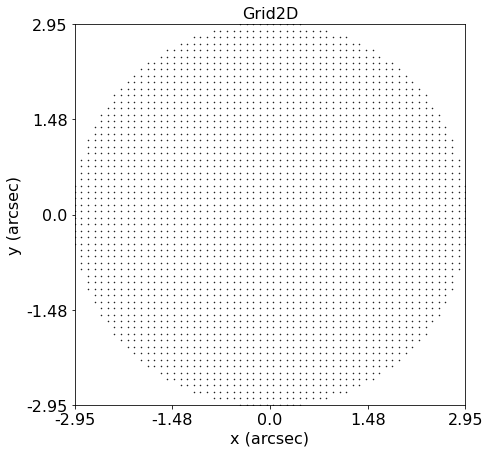

In [8]:
deflections_y = input_deflections.deflections_2d_from_grid(grid=grid)
deflections_x = input_deflections.deflections_2d_from_grid(grid=grid)
grid_plotter = aplt.Grid2DPlotter(grid=grid)
grid_plotter.figure_2d()
aplt.Array2DPlotter(
    array=al.Array2D.manual_native(
        array=deflections_y.native[:, :, 0], pixel_scales=imaging.pixel_scales
    )
)
aplt.Array2DPlotter(
    array=al.Array2D.manual_native(
        array=deflections_y.native[:, :, 1], pixel_scales=imaging.pixel_scales
    )
)

We can use the `InputDeflections` as a `MassProfile` in exactly the same way as any other `MassProfile`. 

Lets use them to represent a lens `Galaxy`, create a `Tracer` object and plot their lensed image of a source.

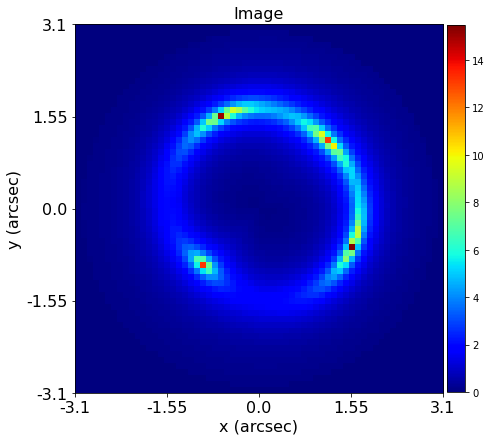

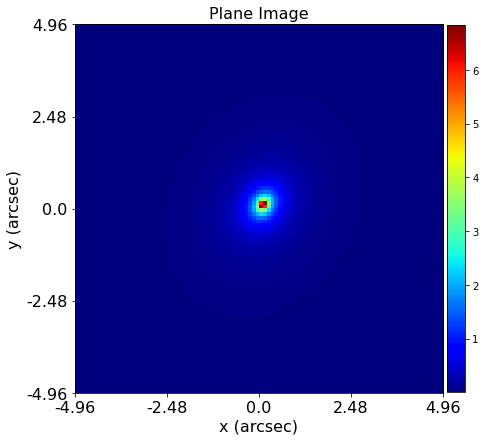

In [9]:
lens_galaxy = al.Galaxy(redshift=0.5, mass=input_deflections)

source_galaxy = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllSersic(
        centre=(0.1, 0.1),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.8, angle=60.0),
        intensity=0.3,
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
tracer_plotter.figures_2d(image=True)
source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=grid)[-1]

plane_plotter = aplt.PlanePlotter(plane=tracer.source_plane, grid=source_plane_grid)
plane_plotter.figures_2d(plane_image=True)

We also apply this mask to our `Imaging` data and fit it using the standard PyAutoLens fitting API.

This means we can ask a crucial question - how well does the source `Galaxy` used above in combination with 
our input deflection angle map fit the image of a strong lens we are comparing to?

In this case, it gives a good fit, because we are using the true deflection angle map and source model!

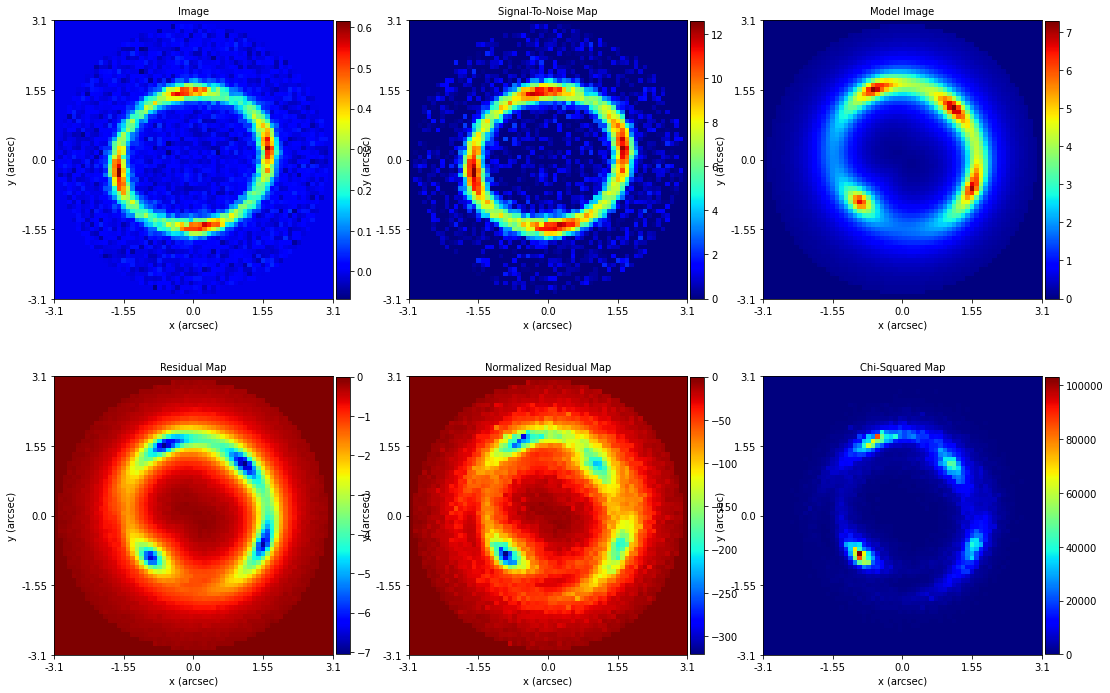

In [10]:
imaging = imaging.apply_mask(mask=mask)
fit_imaging = al.FitImaging(imaging=imaging, tracer=tracer)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit_imaging)
fit_imaging_plotter.subplot_fit_imaging()

We can also use a `Pixelization` and `Regularization` (which combined create an `Inversion`. to reconstruct the
source galaxy.

we'll reconstruct the source on a 30 x 30 `Rectangular` source-plane `Pixelization`.

In [11]:
pixelization = al.pix.Rectangular(shape=(30, 30))

A `Mapper` maps the source-pixels to image-pixels, as shown in the figure below. These mappings are used when 
reconstructing the source galaxy's light.

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/numba/core/ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'slim_indexes' of function 'furthest_grid_2d_slim_index_from'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../PyAutoArray/autoarray/structures/grids/two_d/grid_2d_util.py", line 675:
@decorator_util.jit()
def furthest_grid_2d_slim_index_from(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


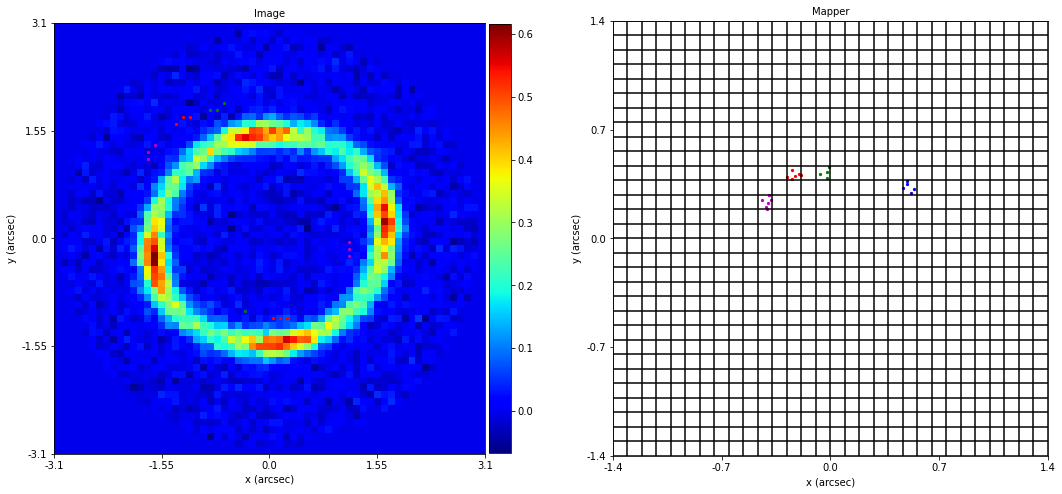

In [12]:
mapper = pixelization.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

visuals_2d = aplt.Visuals2D(pixelization_indexes=[[312], [314], [350], [370]])
include_2d = aplt.Include2D(grid=True)

mapper_plotter = aplt.MapperPlotter(
    mapper=mapper, visuals_2d=visuals_2d, include_2d=include_2d
)

mapper_plotter.subplot_image_and_mapper(image=imaging.image)

We can now use a `Mapper` to perform the `Inversion` and reconstruct the source galaxy's light. 

To perform this `Inverison` we must also input a `Regularization`, which is a prior on how much we smooth the 
source galaxy's light. Try increasing / decreasing the coefficient value to see what effect this has.

In [13]:
regularization = al.reg.Constant(coefficient=1.0)

inversion = al.Inversion(
    dataset=imaging, mapper=mapper, regularization=al.reg.Constant(coefficient=1.0)
)

Finally, lets plot: 

 - The reconstruction of the source _Galaxy- in the source-plane.
 - The corresponding reconstructed image-plane image of the lensed source `Galaxy` (which accounts for PSF blurring).
 - The residuals of the fit to the `Imaging`.

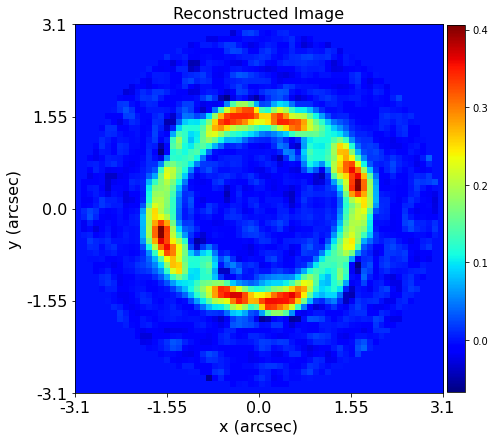

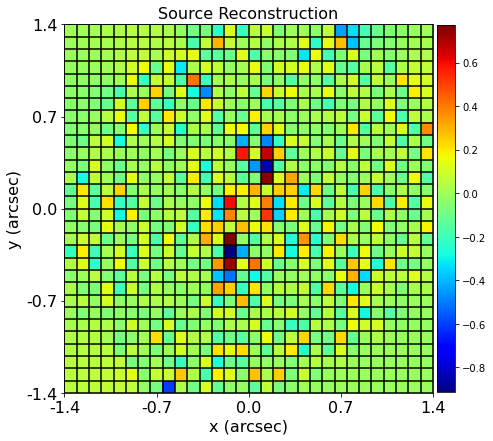

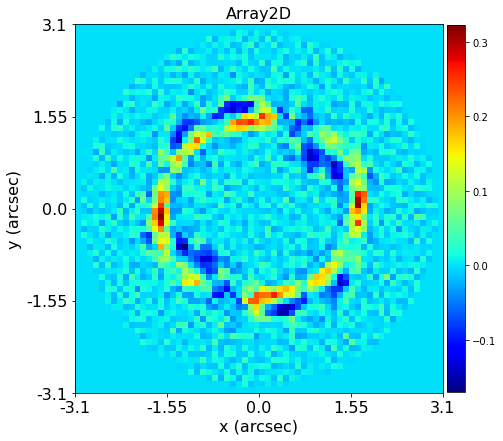

In [14]:
inversion_plotter = aplt.InversionPlotter(inversion=inversion)
inversion_plotter.figures_2d(reconstructed_image=True, reconstruction=True)

residual_map = imaging.image - inversion.mapped_reconstructed_image
array_plotter = aplt.Array2DPlotter(array=residual_map)
array_plotter.figure_2d()

In this example, we assumed the source galaxy's true `LightProfile` or guessed a value for the `Regularization` 
coefficient. In a realistic settings we may not know this, so checkout the script `input_deflections_model.py` in 
this folder to see how we can use the `InputDeflections` to perform lens modeling whereby we infer the source 
galaxy `LightProfile` or `Inversion`.